In [1]:
# auto reload
%load_ext autoreload
%autoreload 2

# Testing PnP on ETH3D dataset

Install dependencies
```
pip install py7zr torchdata matplotlib
pip install 'portalocker>=2.0.0'
```

The following cell downloads the ETH3D dataset and extracts it to the `data_root` folder. The dataset is about 4.7GB in size. The `batch_sample` is a data generation head connected to the ETH3D datapipe. 

In [2]:
import torch
from functools import partial
import os
from eth3d import download_pipe, load_pipe
import numpy as np
data_root = 'data_cache_eth3d_dp'
os.makedirs(data_root, exist_ok=True)

scenes = [
    "courtyard_dslr_undistorted.7z",
    "facade_dslr_undistorted.7z",
    "delivery_area_dslr_undistorted.7z",
    "statue_dslr_undistorted.7z",]

files = ['DSC_0323.JPG', 'DSC_0350.JPG', 'DSC_0685.JPG', 'DSC_0490.JPG']

def sample(num_points: int, batch_size: int,
           pixels: np.ndarray, point_ids: np.ndarray,
           point_dict: dict,):
    visible = point_ids >= 0
    pixels = pixels[visible]
    point_ids = point_ids[visible]

    draw = np.random.choice(len(point_ids), (batch_size, num_points), replace=True)
    sampled_point_ids = point_ids[draw]
    sampled_pixels = pixels[draw]
    sampled_points = np.zeros((batch_size, num_points, 3), 
                              dtype=next(iter(point_dict.values()))[0].dtype)
    for i in range(batch_size):
        sampled_points[i] = np.array([point_dict[key][0] for key in sampled_point_ids[i]])

    return sampled_pixels, sampled_points


img = load_pipe(download_pipe(data_root, scenes=scenes))
for _ in img:
    pass

/home/ztzhan/miniconda3/lib/python3.10/site-packages/torch/utils/data/datapipes/utils/common.py:137: UserWarning: Local function is not supported by pickle, please use regular python function or functools.partial instead.
  warnings.warn(


Next we instantiate a `PnP` object. Test our solver and plot accuracy on each of the selected four images. 

/home/ztzhan/miniconda3/lib/python3.10/site-packages/torch/utils/data/datapipes/utils/common.py:137: UserWarning: Local function is not supported by pickle, please use regular python function or functools.partial instead.
  warnings.warn(
/home/ztzhan/miniconda3/lib/python3.10/site-packages/torch/utils/data/datapipes/utils/common.py:145: UserWarning: Lambda function is not supported by pickle, please use regular python function or functools.partial instead.
  warnings.warn(
/home/ztzhan/miniconda3/lib/python3.10/site-packages/torch/utils/data/datapipes/iter/combining.py:297: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "


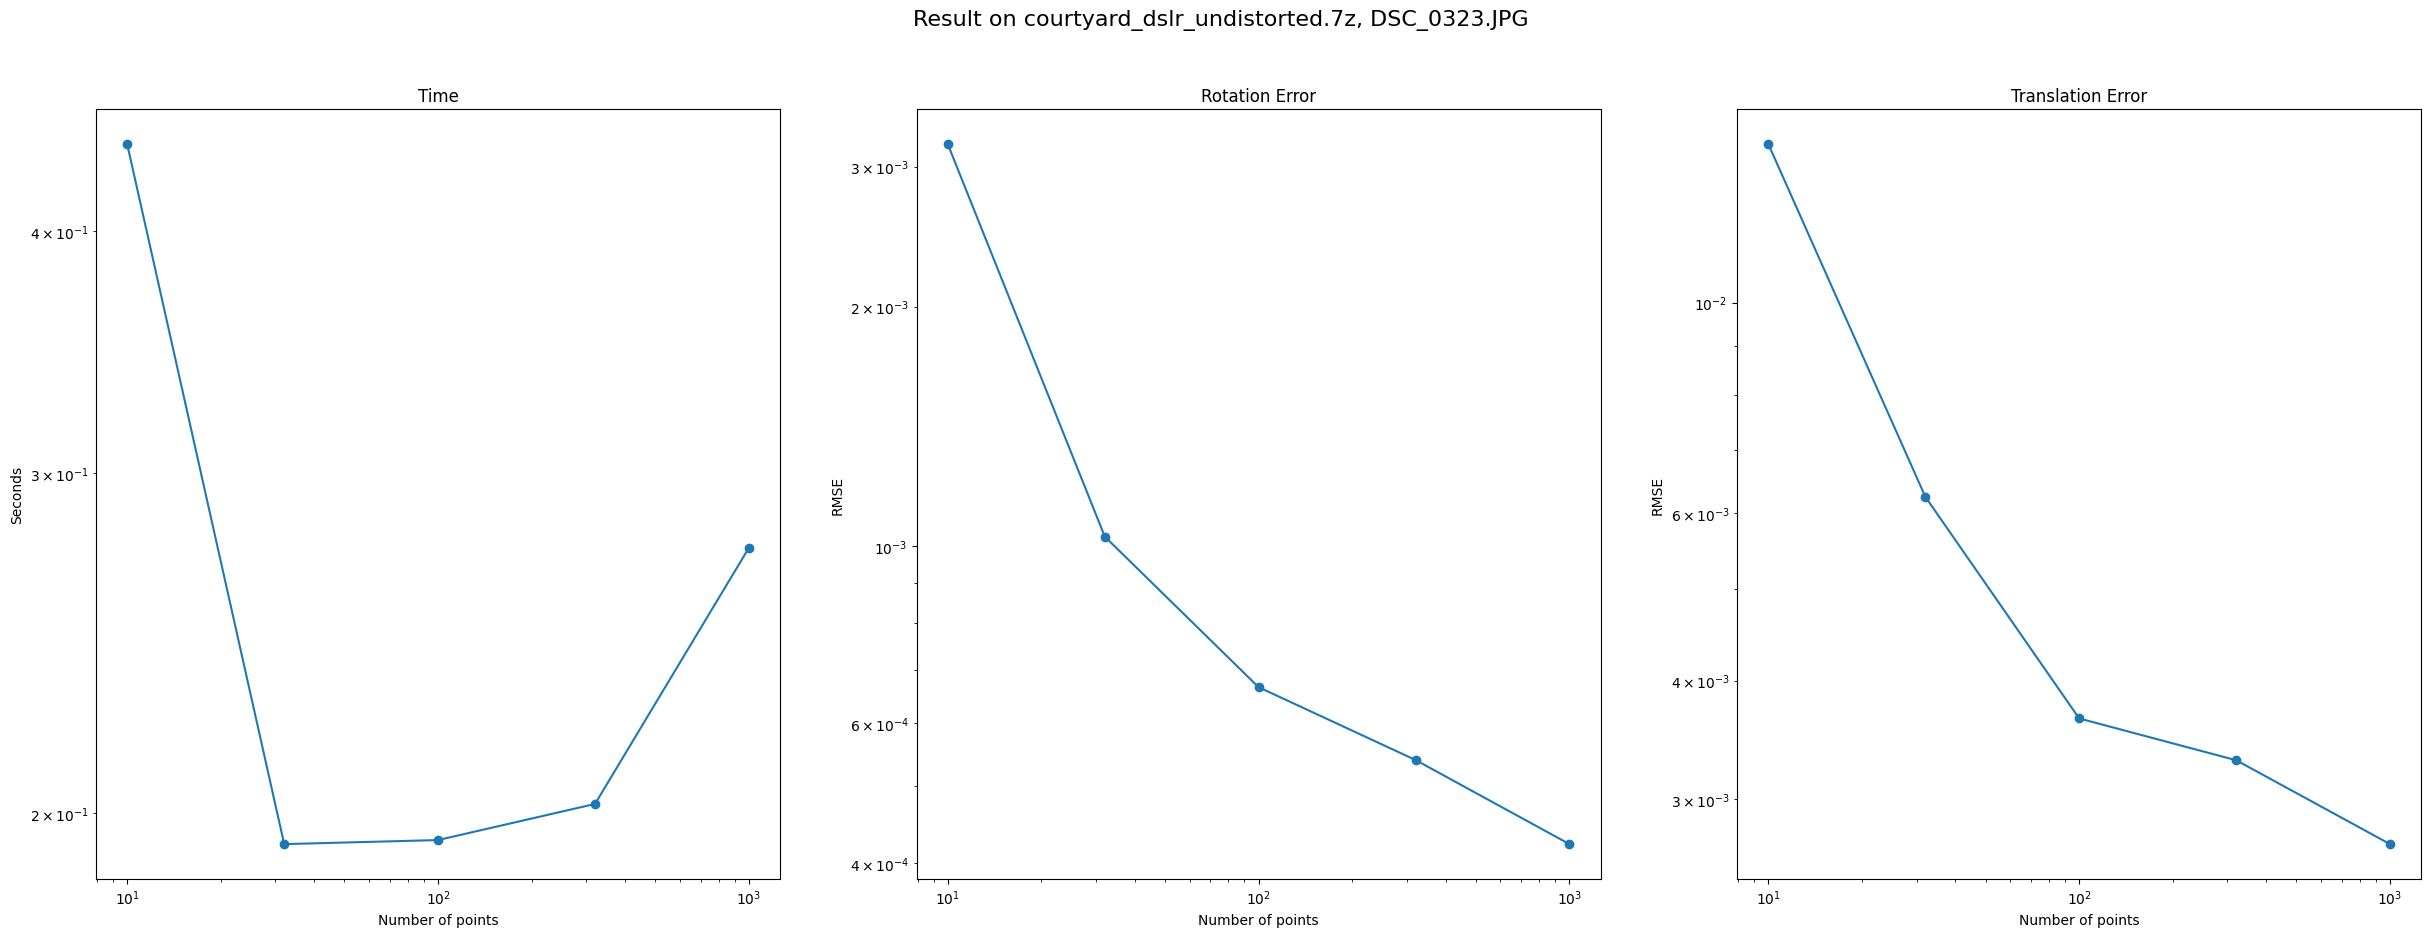

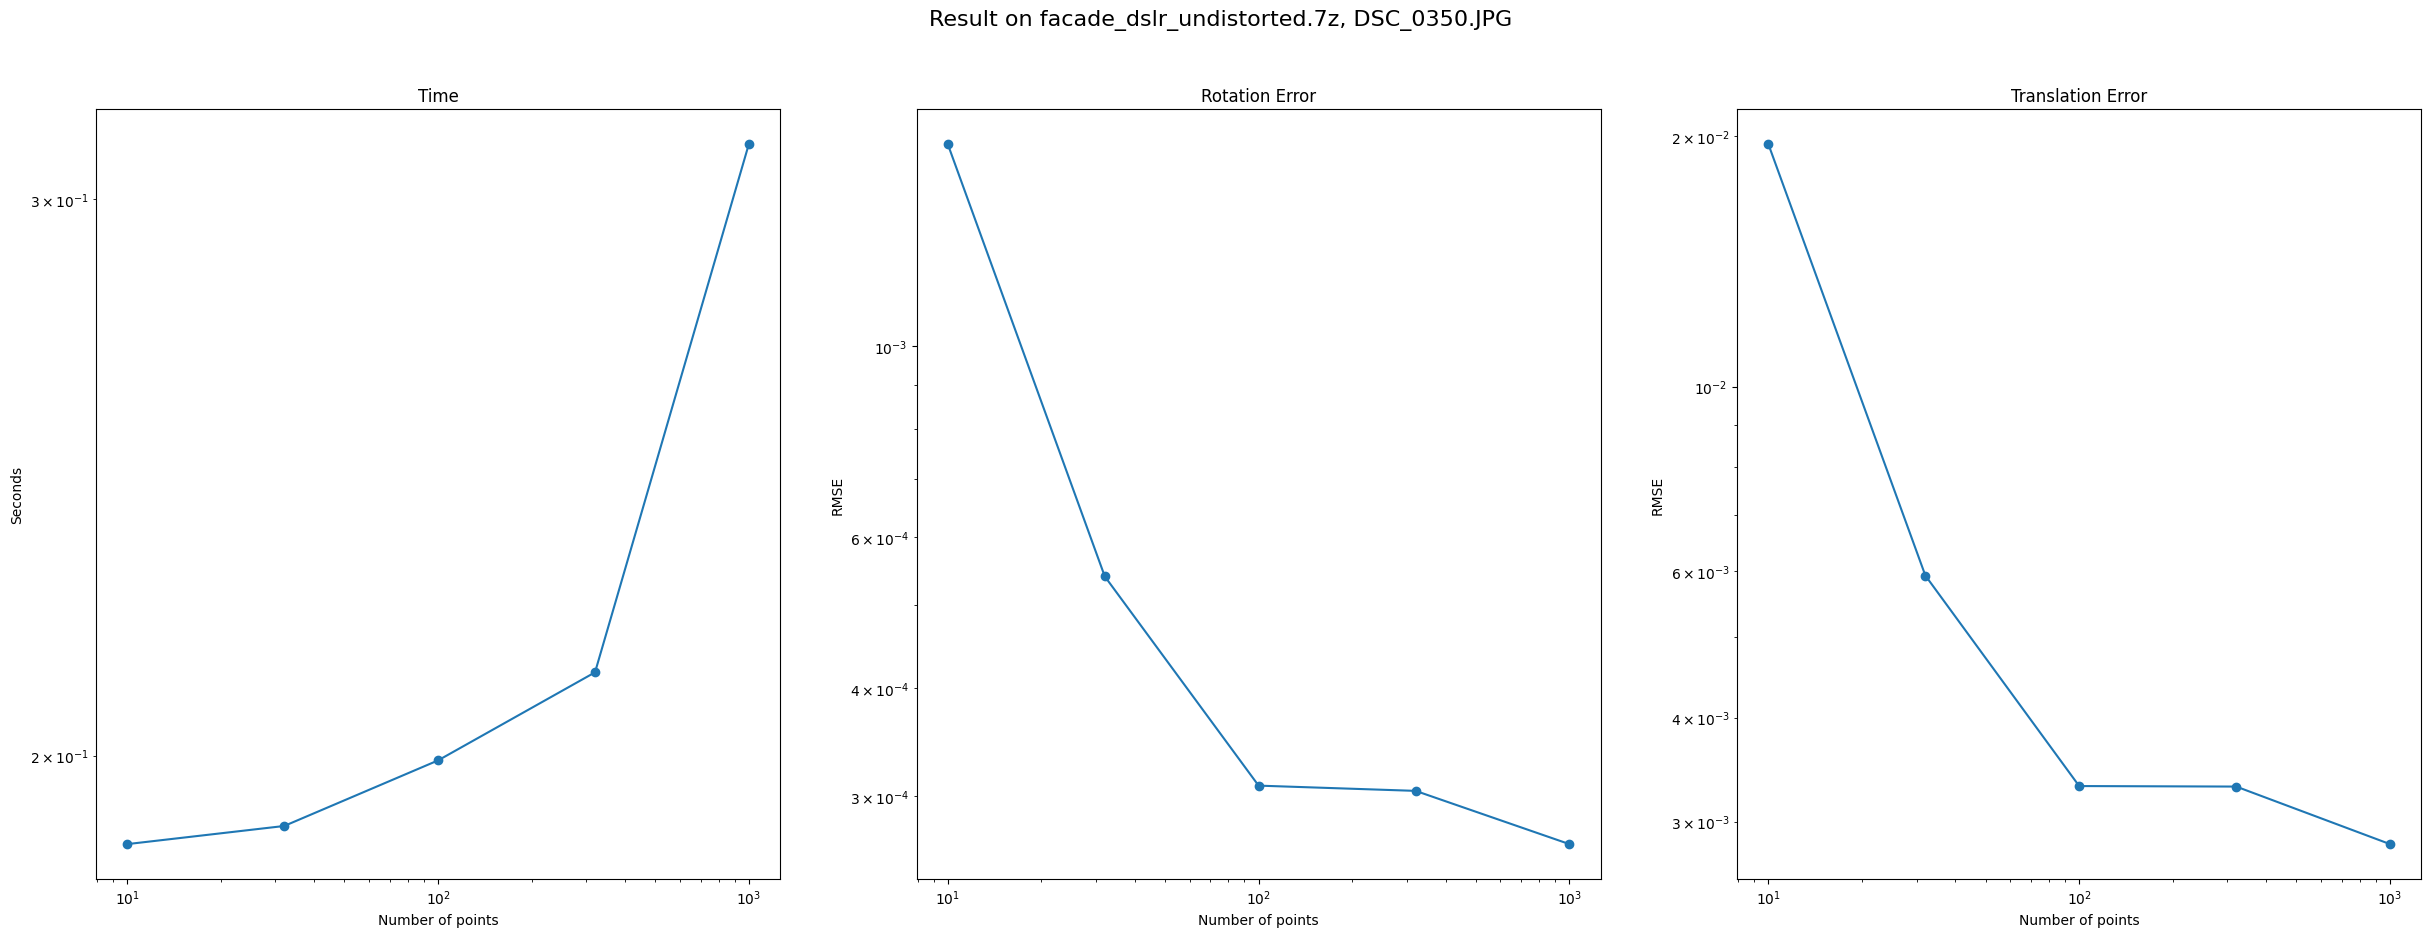

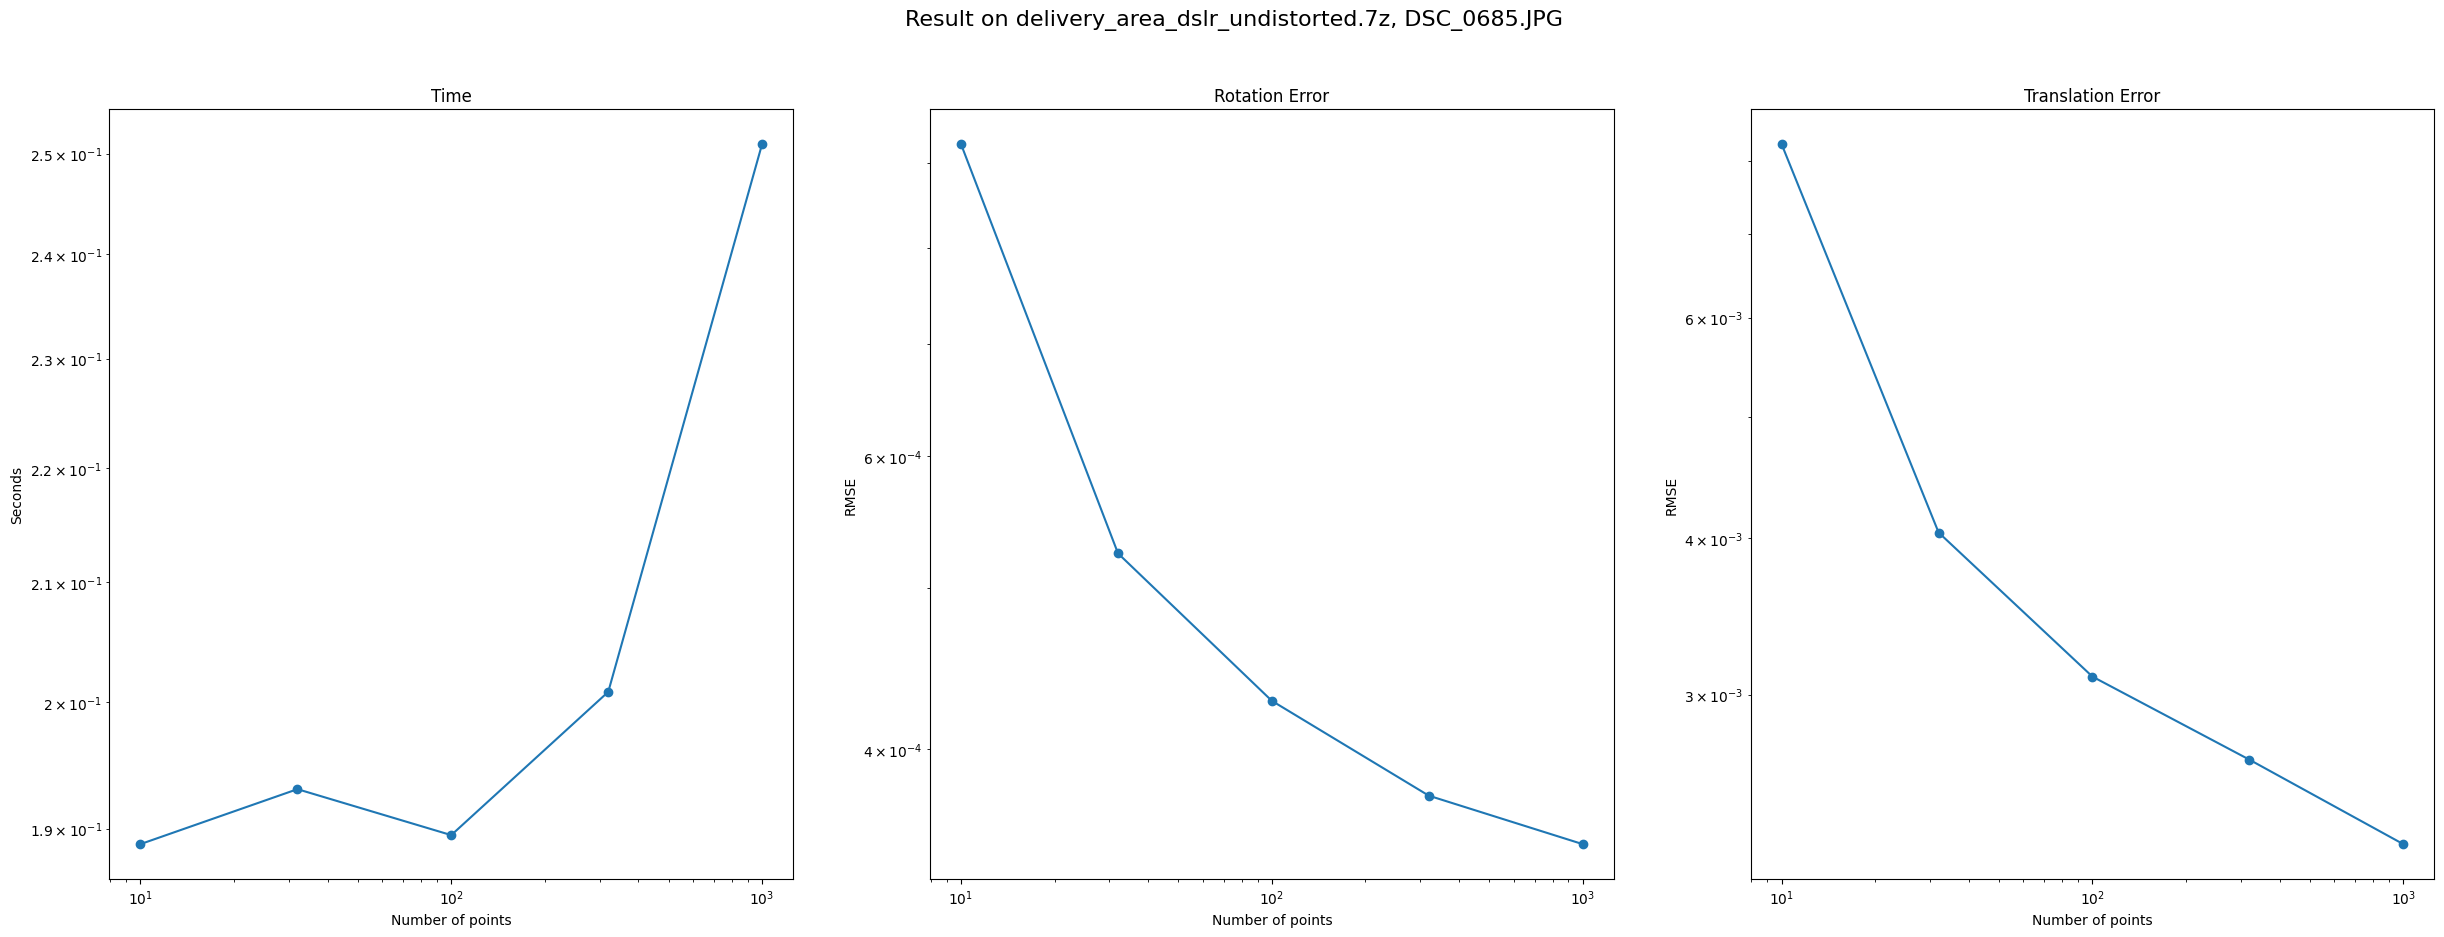

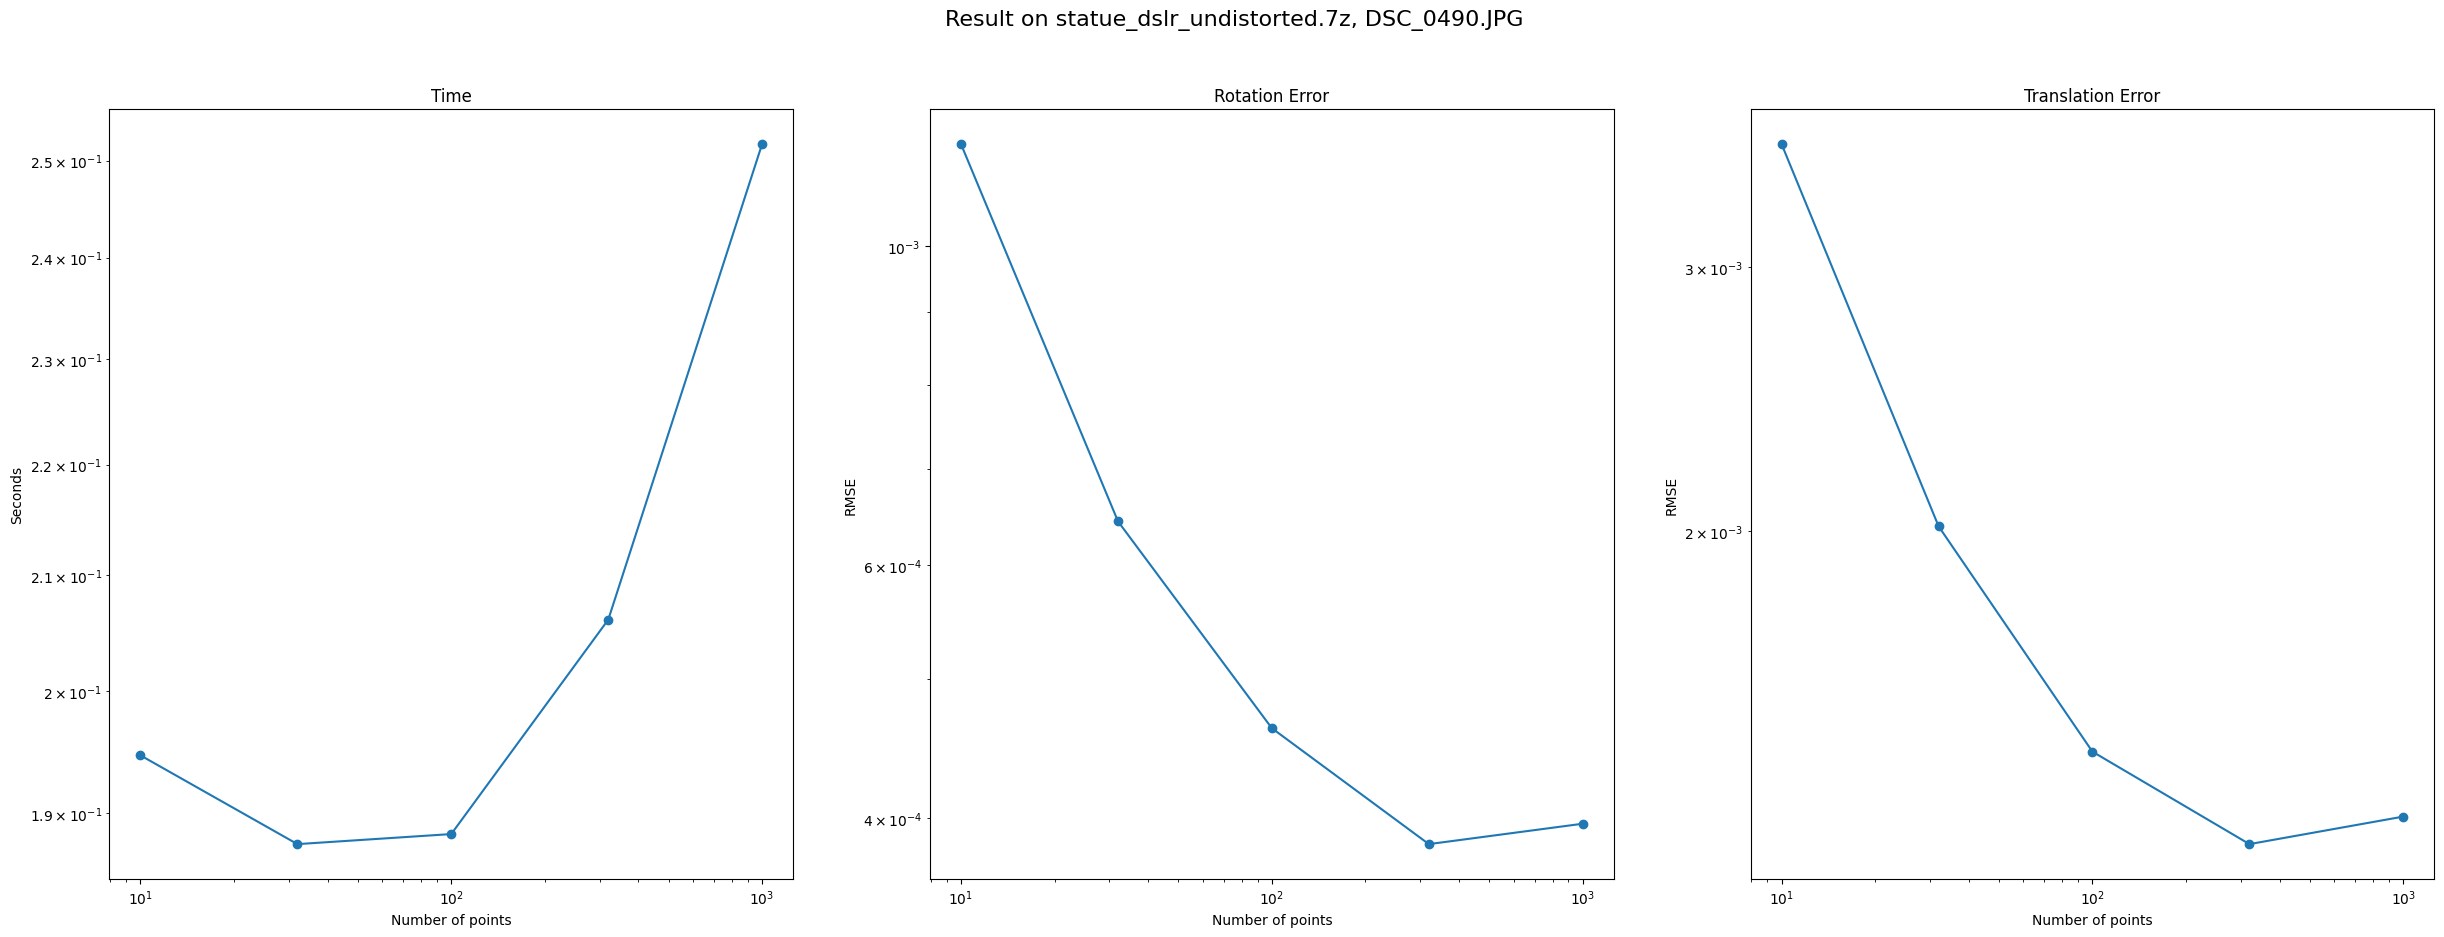

In [3]:
import pypose as pp
from time import perf_counter
import matplotlib.pyplot as plt

solver = pp.module.EPnP()
batch_size = 100
nums = (10, 32, 100, 320, 1000)
for scene, file in zip(scenes, files):
    r_error = []
    t_error = []
    time = []
    img = load_pipe(download_pipe(data_root, scenes=[scene]))\
        .filter(lambda x: file in x['jpg_name'])
    for num_points in nums:
        img = img.map(partial(sample, num_points, batch_size), 
                      input_col=('pixels', 'point_ids', 'point'), output_col='sample')
        for idx, i in enumerate(img):
            pixels, points = i['sample']
            groundtruth = i['pose']
            camera = i['camera'][i['camera_id']]

            points = torch.from_numpy(points).to(torch.float64)
            pixels = torch.from_numpy(pixels).to(points)
            camera = torch.from_numpy(camera).to(points)

            start = perf_counter()
            pose = solver(points, pixels, camera)
            end = perf_counter()
            
            time.append(end - start)
            r_error.append(torch.norm(groundtruth.rotation().matrix() - 
                                      pose.rotation().matrix(), dim=(-1, -2)).pow(2).mean().sqrt())
            t_error.append(torch.norm(groundtruth.translation() - 
                                      pose.translation(), dim=-1).pow(2).mean().sqrt())
            assert idx == 0, "Only one image is expected"
    ylabels = ['Seconds', 'RMSE', 'RMSE']
    title = ['Time', 'Rotation Error', 'Translation Error']
    fig, axs = plt.subplots(1, len(ylabels), figsize=(10 * len(title), 10))
    for idx, item in enumerate([time, r_error, t_error]):
        ax = axs[idx]
        ax.plot(nums, item, 'o-')
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xlabel('Number of points')
        ax.set_ylabel(ylabels[idx])
        ax.set_title(title[idx])
    fig.suptitle("Result on " + scene + ', ' + file, fontsize=16)
